This notebook contains the code relating to section 4.2 of the thesis, which covers preliminary aneurysm segmentation experimentation: segmentation of whole 2D slices.

# Installations

In [ ]:
pip -q install tensorflow_addons

     |████████████████████████████████| 1.1 MB 5.3 MB/s 


In [ ]:
import numpy as np
import nibabel
import os
import tensorflow as tf
import matplotlib.pyplot as plt

import albumentations as A

from __future__ import print_function

from skimage.transform import resize
from skimage.io import imsave
from skimage.segmentation import mark_boundaries
from skimage.exposure import rescale_intensity
from skimage import io
import tensorflow as tf

import keras
from keras.models import Model, Sequential
from tensorflow.keras.layers.experimental import preprocessing
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, Dropout, BatchNormalization, Flatten, Dense
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.callbacks import History
from tensorflow.keras.utils import plot_model
from tensorflow_addons.optimizers import AdamW
from tensorflow.keras import layers

from tqdm.auto import tqdm

os.getcwd()

'/content'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q git+https://github.com/tensorflow/examples.git

from tensorflow_examples.models.pix2pix import pix2pix

    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [ ]:
def get_tpu_strategy():
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver(
            tpu="grpc://" + os.environ["COLAB_TPU_ADDR"]
        )  # TPU detection
        print("Running on TPU ", tpu.cluster_spec().as_dict()["worker"])
    except ValueError:
        raise BaseException("ERROR: Not connected to a TPU runtime")

    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    return tf.distribute.TPUStrategy(tpu)

In [ ]:
tpu_strategy = get_tpu_strategy()

Running on TPU  ['10.116.35.34:8470']
INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.116.35.34:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.116.35.34:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
# give permission to read data from google cloud bucket
from google.colab import auth
auth.authenticate_user()

# Functions for loading data in TFRecords format

In [ ]:
def _parse_image_function(example_proto):

    """
    Reads from TFRecord file
    Returns a tf.train.Example object (can be read like a dictionary)
    """

    image_feature_description = {

        "image_raw": tf.io.FixedLenFeature([256 * 256], tf.float32),
        "mask_raw": tf.io.FixedLenFeature([256 * 256], tf.int64),
    }

    # Parse the input tf.train.Example proto using the dictionary above.
    return tf.io.parse_single_example(example_proto, image_feature_description)


def _unpack_proto(example_proto):

    """
    Extract image and mask from example_proto object
    """

    image = example_proto["image_raw"]
    image = tf.reshape(image, [256, 256, 1])

    mask = example_proto["mask_raw"]
    mask = tf.reshape(mask, [256, 256])

    return image, mask

In [ ]:
### Data Augmentation

def _unpack_proto_aug(example_proto):

    """
    Extract image and mask from example_proto object
    """

    image = example_proto["image_raw"]
    image = tf.reshape(image, [256, 256, 1])

    mask = example_proto["mask_raw"]
    mask = tf.reshape(mask, [256, 256])

    # DATA AUGMENTATION
    if tf.random.uniform(()) > 0.5:
      image = tf.image.flip_left_right(image)
      mask = tf.image.flip_left_right(tf.expand_dims(mask, [2]))
      mask = tf.squeeze(mask)

    if tf.random.uniform(()) > 0.5:
      image = tf.image.rot90(image)
      mask = tf.image.rot90(tf.expand_dims(mask, [2]))
      mask = tf.squeeze(mask)

    return image, mask


In [ ]:
def optimise_dataset(ds):

  """
  Improve performance of tensorflow dataset
  """

  ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
  # ds = ds.cache()
  return ds

def prepare_data(ds, shuffle=True):
  """
  Normalise, batch, shuffle and optimise the dataset
  """
  # ds = normalise(ds)
  if shuffle:
    ds = ds.shuffle(5000)
  batch_size = 8 * tpu_strategy.num_replicas_in_sync # 16*8 (tpu_strategy.num_replicas_in_sync value shown in output of previous cell)
  ds = ds.batch(batch_size, drop_remainder=True)
  ds = optimise_dataset(ds)
  return ds

def to_3_channels(image, mask):
  img_shape = (256, 256)
  image = tf.reshape(tf.repeat(image, 3), (*img_shape, 3))
  # mask = tf.reshape(tf.repeat(mask, 3), (*img_shape, 3))
  return image, mask

In [ ]:
def add_sample_weights(image, mask):
  # The weights for each class, with the constraint that:
  #     sum(class_weights) == 1.0
  class_weights = tf.constant([1.0, 10.0])
  class_weights = class_weights/tf.reduce_sum(class_weights)

  # Create an image of `sample_weights` by using the label at each pixel as an 
  # index into the `class weights` .
  sample_weights = tf.gather(class_weights, indices=tf.cast(mask, tf.int32))

  return image, mask, sample_weights

# Load training & validation data

In [ ]:
# retrieve training data from google cloud and create dataset

train_nonempty_gcs_pattern = "gs://aneurysm_seg_orig/train_non_empty*"
train_nonempty_filenames = tf.io.gfile.glob(train_nonempty_gcs_pattern)

train_nonempty_ds = tf.data.TFRecordDataset(train_nonempty_filenames)
train_nonempty_ds = train_nonempty_ds.map(_parse_image_function)
train_nonempty_ds = train_nonempty_ds.map(_unpack_proto_aug)
train_nonempty_ds = train_nonempty_ds.map(to_3_channels)

train_empty_gcs_pattern = "gs://aneurysm_seg_orig/train__empty*"
train_empty_filenames = tf.io.gfile.glob(train_empty_gcs_pattern)

train_empty_ds = tf.data.TFRecordDataset(train_empty_filenames)
train_empty_ds = train_empty_ds.map(_parse_image_function)
train_empty_ds = train_empty_ds.map(_unpack_proto_aug)
train_empty_ds = train_empty_ds.map(to_3_channels)

# sample equally from empty & non-empty
train_datasets = [train_nonempty_ds.repeat(), train_empty_ds.repeat()]
train_ds = tf.data.experimental.sample_from_datasets(train_datasets, [0.8,0.2]) # class weighting

train_ds = prepare_data(train_nonempty_ds)

In [ ]:
# retrieve validation data from google cloud and create dataset

val_nonempty_gcs_pattern = "gs://aneurysm_seg_orig/val_non_empty*"
val_nonempty_filenames = tf.io.gfile.glob(val_nonempty_gcs_pattern)

val_nonempty_ds = tf.data.TFRecordDataset(val_nonempty_filenames)
val_nonempty_ds = val_nonempty_ds.map(_parse_image_function)
val_nonempty_ds = val_nonempty_ds.map(_unpack_proto)
val_nonempty_ds = val_nonempty_ds.map(to_3_channels)

val_empty_gcs_pattern = "gs://aneurysm_seg_orig/val__empty*"
val_empty_filenames = tf.io.gfile.glob(val_empty_gcs_pattern)

val_empty_ds = tf.data.TFRecordDataset(val_empty_filenames)
val_empty_ds = val_empty_ds.map(_parse_image_function)
val_empty_ds = val_empty_ds.map(_unpack_proto)
val_empty_ds = val_empty_ds.map(to_3_channels)

# sample equally from empty & non-empty
val_datasets = [val_nonempty_ds.repeat(), val_empty_ds.repeat()]
val_ds = tf.data.experimental.sample_from_datasets(val_datasets, [0.8,0.2]) # class weighting

val_ds = prepare_data(val_nonempty_ds)

# View training & validation images & masks

In [ ]:
for images, masks in train_ds.take(1):  
      numpy_images = images.numpy()
      numpy_masks = masks.numpy()

In [ ]:
def compare_train_img_mask(img_num):

  plt.subplot(1,2,1)
  plt.title('Training Image {}'.format(img_num))
  plt.imshow(numpy_images[img_num], cmap='gray')

  plt.subplot(1,2,2)
  plt.title('Training mask {}'.format(img_num))
  plt.imshow(numpy_masks[img_num].reshape((256,256)), cmap='gray')

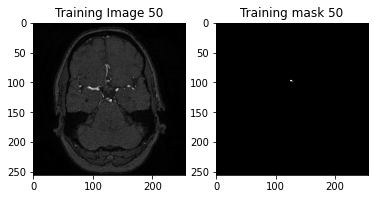

In [ ]:
compare_train_img_mask(50)

# Loss Function

In [ ]:
# return our metric and loss

with tpu_strategy.scope():

  def dice_coef(y_true, y_pred, smooth=1e-16):
    y_true_f = tf.cast(K.flatten(y_true), tf.float32)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)

    return (2* intersection + smooth)/(K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    

  def dice_coef_loss(y_true, y_pred):
    return (1.0 - dice_coef(y_true, y_pred))


  def mixed_loss(y_true, y_pred):

    y_true_f = tf.cast(K.flatten(y_true), tf.float32)
    y_pred_f = K.flatten(y_pred)

    bce = tf.keras.losses.binary_crossentropy(y_true_f, y_pred_f, from_logits=True)
    dice = dice_coef(y_true, y_pred)

    return bce + (1.0 - dice)

# Model Architecture

### Original U-Net (1.0, 1.1)

In [ ]:
with tpu_strategy.scope():

    inputs = Input((256, 256, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])


### 1.4 (U-Net with dropout)

In [ ]:
with tpu_strategy.scope():

  inputs = Input(shape=(256, 256, 1))
  conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
  conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  drop1 = Dropout(0.2)(pool1)

  conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
  conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  drop1 = Dropout(0.2)(pool2)

  conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
  conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  drop1 = Dropout(0.2)(pool3)

  conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
  conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
  drop1 = Dropout(0.2)(pool4)

  conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
  conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

  up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
  drop6 = Dropout(0.2)(up6)
  conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(drop6)
  conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

  up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
  drop7 = Dropout(0.2)(up7)
  conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(drop7)
  conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

  up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
  drop8 = Dropout(0.2)(up8)
  conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(drop8)
  conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

  up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
  drop9 = Dropout(0.2)(up9)
  conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(drop9)
  conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

  conv10 = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(conv9)

  model = Model(inputs=[inputs], outputs=[conv10])

In [ ]:
model.summary()

### Pre-trained - from tensorflow tutorial (1.2, 1.3)

In [ ]:
with tpu_strategy.scope():

  OUTPUT_CHANNELS = 1

  base_model = tf.keras.applications.MobileNetV2(input_shape=[256, 256, 3], include_top=False) # ImageNet weights only work with 3 channel images

  # Use the activations of these layers
  layer_names = [
      'block_1_expand_relu',   # 64x64
      'block_3_expand_relu',   # 32x32
      'block_6_expand_relu',   # 16x16
      'block_13_expand_relu',  # 8x8
      'block_16_project',      # 4x4
  ]
  base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

  # Create the feature extraction model
  down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

  down_stack.trainable = False

In [ ]:
!pip install -q git+https://github.com/tensorflow/examples.git

In [ ]:
from tensorflow_examples.models.pix2pix import pix2pix

with tpu_strategy.scope():

  up_stack = [
      pix2pix.upsample(512, 3),  # 4x4 -> 8x8
      pix2pix.upsample(256, 3),  # 8x8 -> 16x16
      pix2pix.upsample(128, 3),  # 16x16 -> 32x32
      pix2pix.upsample(64, 3),   # 32x32 -> 64x64
  ]

In [ ]:
def rescale_output(y_pred):

  y_pred = tf.clip_by_value(y_pred, clip_value_min=0., clip_value_max=1.) # force values to be between 0 and 1

  return y_pred

In [ ]:
with tpu_strategy.scope(): 

  def unet_model(output_channels):

    inputs = tf.keras.layers.Input(shape=[256, 256, 3])
    base_model = tf.keras.applications.MobileNetV2(input_shape=[256, 256, 3], include_top=False) # ImageNet weights only work with 3 channel images



    ### ADDING L2 REGULARISATION ###
    # penalty = 0.01
    # regularizer = tf.keras.regularizers.l2(penalty)

    # for layer in base_model.layers:
    #     for attr in ['kernel_regularizer']:
    #         if hasattr(layer, attr):
    #           setattr(layer, attr, regularizer)

    #  # When we change the layers attributes, the change only happens in the model config file
    # model_json = base_model.to_json()

    # # Save the weights before reloading the model.
    # weights_path = "/content/drive/My Drive/Masters Project/Vascular Segmentation/Model Weights/test5.h5"
    # # weights_path = os.path.join(weights_path, 'test1.h5')
    # base_model.save_weights(weights_path)

    # # load the model from the config
    # base_model = tf.keras.models.model_from_json(model_json)
    
    # # Reload the model weights
    # base_model.load_weights(weights_path, by_name=True)




    # Use the activations of these layers
    layer_names = [
        'block_1_expand_relu',   # 48x48
        'block_3_expand_relu',   # 24x24
        'block_6_expand_relu',   # 12x12
        'block_13_expand_relu',  # 6x6
        'block_16_project',      # 3x3
    ]
    base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

    # # Create the feature extraction model
    down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

    down_stack.trainable = False

    up_stack = [
        pix2pix.upsample(512, 3),  # 4x4 -> 8x8
        pix2pix.upsample(256, 3),  # 8x8 -> 16x16
        pix2pix.upsample(128, 3),  # 16x16 -> 32x32
        pix2pix.upsample(64, 3),   # 32x32 -> 64x64
    ]

    skips = down_stack(inputs)
    x = skips[-1] # final output of encoder
    skips = reversed(skips[:-1]) # all outputs of encoder except final, reversed
    # Upsampling and establishing the skip connections
    
    for up, skip in zip(up_stack, skips):
      x = up(x) # pass output of encoder through decoder (iterates through outputs of decoder)
      concat = tf.keras.layers.Concatenate() 
      x = concat([x, skip]) # cross-link: output of decoder concatenated with encoder output
    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2,
        padding='same')  #64x64 -> 128x128

    normalise_output = tf.keras.layers.Lambda(rescale_output)

    x = last(x)

    # x = tf.keras.activations.softmax(x)
    x = normalise_output(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

### Model Summary

In [ ]:
model.summary()

Model: "model_47"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
model_46 (Functional)           [(None, 128, 128, 96 1841984     input_21[0][0]                   
__________________________________________________________________________________________________
sequential_16 (Sequential)      (None, 16, 16, 512)  1476608     model_46[0][4]                   
__________________________________________________________________________________________________
concatenate_56 (Concatenate)    (None, 16, 16, 1088) 0           sequential_16[0][0]              
                                                                 model_46[0][3]            

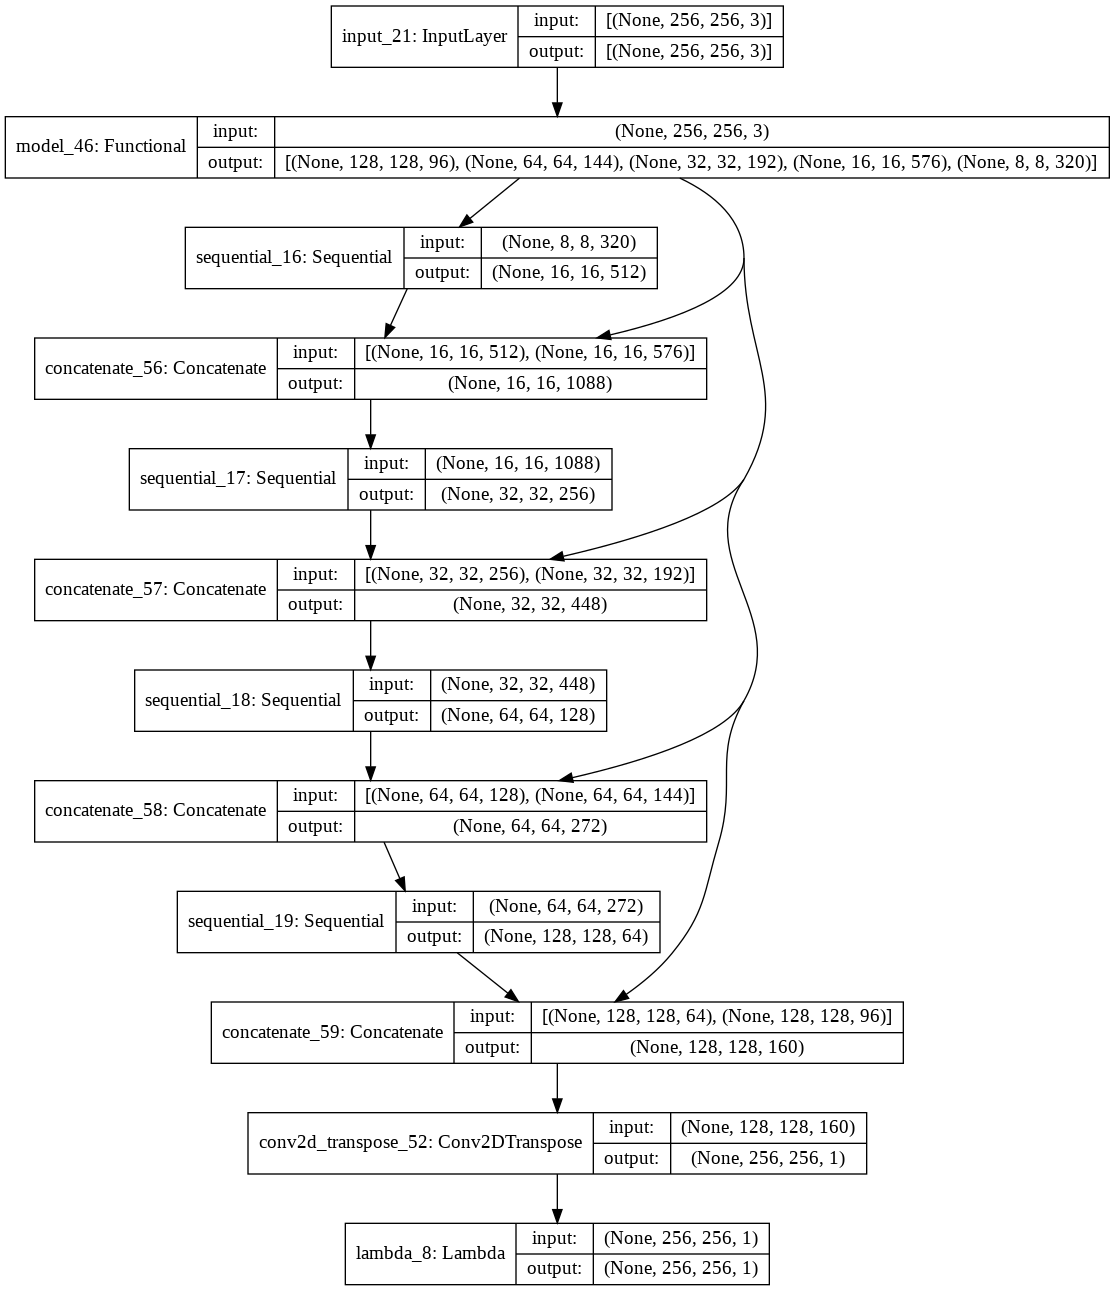

In [ ]:
# display model architecture

plot_model(model, show_shapes=True, rankdir='TB')

# Learning rate scheduler & Early Stopping

In [ ]:
def build_learning_rate_cycler(
    lr_start=1e-5,
    lr_max=5e-5,
    lr_min=1e-6,
    lr_rampup_epochs=10,
    lr_sustain_epochs=2,
    lr_exp_decay=0.9,
):
    lr_max = lr_max

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_exp_decay ** (
                epoch - lr_rampup_epochs - lr_sustain_epochs
            ) + lr_min
        return lr

    return lrfn

lr_cycler = build_learning_rate_cycler(
          lr_start=1e-5,
          lr_max=3e-4,
          lr_min=1e-6,
          lr_rampup_epochs=20,
          lr_sustain_epochs=0,
          lr_exp_decay=0.9,
      )   


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
                    monitor='val_loss',
                    patience=15,
                    restore_best_weights=True,
                    mode='auto',
                )

# Find Optimal Learning Rate

In [ ]:
loss = dice_coef_loss
metrics = dice_coef

model = unet_model(output_channels=1)

model.compile(optimizer=Adam(), loss=loss, metrics=metrics)

initial_weights = model.get_weights()
len(initial_weights)

273

In [ ]:
def find_learning_rate(num_rates=50):
    rates = np.logspace(-5, -1, num=num_rates)
    img, label = list(train_ds.take(1))[0]
    losses = []
    for rate in tqdm(rates):

          model.compile(optimizer=Adam(learning_rate=rate), loss=loss, metrics=metrics)
          model.set_weights(initial_weights)
          model.fit(img, label, epochs=5, verbose=0)
          losses.append(model.history.history['loss'][-1])
    return losses, rates

losses, rates = find_learning_rate(50)

  0%|          | 0/50 [00:00<?, ?it/s]

(array([0.9978, 0.998 , 0.9982, 0.9984, 0.9986, 0.9988, 0.999 , 0.9992,
        0.9994, 0.9996]), <a list of 10 Text major ticklabel objects>)

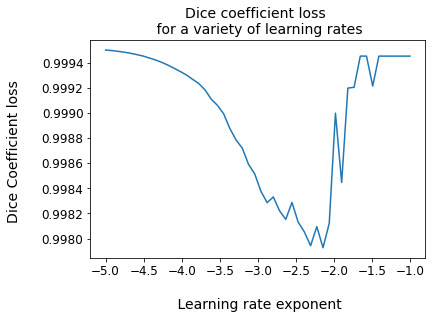

In [ ]:
plt.plot(np.log10(rates), np.clip(losses, 0, 2))
plt.title('Dice coefficient loss \n for a variety of learning rates', size=14)
plt.xlabel('\n Learning rate exponent', size=14)
plt.ylabel('Dice Coefficient loss \n', size=14)
plt.xticks(size=12)
plt.yticks(size=12)

# Training Variations of original Model

In [ ]:
with tpu_strategy.scope():

  # train AND save weights 

  print('Creating and compiling model...')

  model = unet_model(output_channels=1)

  lr = 10**(-3.5)
  loss = dice_coef_loss
  metrics = dice_coef

  # model = Model(inputs=[inputs], outputs=[conv10])
  
  model.compile(optimizer=Adam(learning_rate=lr), loss=loss, metrics=metrics)

  print('Fitting model...')

  EPOCHS = 50

  # train on aneurysm-positive & aneurysm-negative
  # history = model.fit(
  #     train_ds.map(add_sample_weights), 
  #     epochs=EPOCHS,
  #     steps_per_epoch=5,
  #     validation_data=val_ds.repeat(), # callbacks = [early_stopping], # tf.keras.callbacks.LearningRateScheduler(lr_cycler, verbose=1),
  #     validation_steps=1)

  history = model.fit(
    train_ds.map(add_sample_weights).repeat(),
    steps_per_epoch=2, 
    epochs=EPOCHS,
    validation_data=val_ds.repeat(),
    validation_steps = 1,
    callbacks = [early_stopping]) # tf.keras.callbacks.LearningRateScheduler(lr_cycler, verbose=1),


Creating and compiling model...


Fitting model...
Epoch 1/50
2/2 [==============================] - ETA: 0s - loss: 0.0911 - dice_coef: 4.9295e-04 WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 1 batches). You may need to use the repeat() function when building your dataset.


OutOfRangeError: ignored

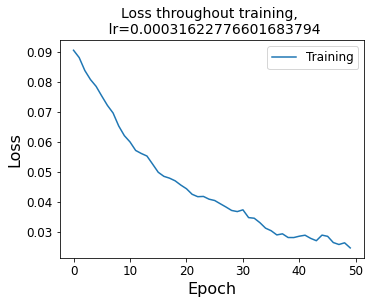

In [ ]:
plt.figure(figsize=(12, 4)) 

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Training')
# plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epoch', size=16)
plt.ylabel('Loss', size=16)
plt.xticks(size=12)
plt.yticks(size=12)
plt.title('Loss throughout training, \n lr={}'.format(lr), size=14)
plt.legend(prop={'size': 12})

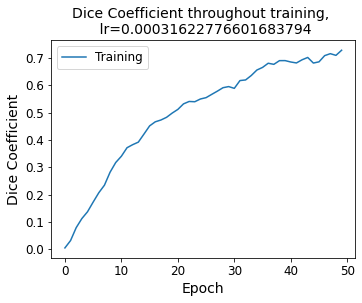

In [ ]:
plt.figure(figsize=(12, 4)) 

plt.subplot(1,2,2)
plt.plot(history.history['dice_coef'], label='Training')
# plt.plot(history.history['val_dice_coef'], label='Validation')
plt.xlabel('Epoch', size=14)
plt.ylabel('Dice Coefficient', size=14)
plt.xticks(size=12)
plt.yticks(size=12)
plt.title('Dice Coefficient throughout training, \n lr={}'.format(lr), size=14)
plt.legend(prop={'size': 12})

# Training Pre-trained model

In [ ]:
with tpu_strategy.scope():

  model = unet_model(OUTPUT_CHANNELS)

  lr = 1e-3
  loss = tf.keras.losses.binary_crossentropy
  metrics = dice_coef

  model.compile(optimizer=AdamW(weight_decay=1e-6, learning_rate=lr),
                loss=loss,
                metrics=metrics)

  EPOCHS = 20

  ## aneurysm-positive & aneurysm-negative
  # history = model.fit(train_ds.take(5), epochs=EPOCHS, steps_per_epoch=50,
  #                           validation_data=val_ds.take(2), validation_steps=10) # , callbacks = [tf.keras.callbacks.LearningRateScheduler(lr_cycler, verbose=1), early_stopping])

  ## aneurysm-positive only
  history = model.fit(train_ds.take(5), epochs=EPOCHS,
                            validation_data=val_ds.take(2)) # , callbacks = [tf.keras.callbacks.LearningRateScheduler(lr_cycler, verbose=1), early_stopping])


Epoch 1/20
      3/Unknown - 18s 45ms/step - loss: 0.4373 - dice_coef: 0.0016   WARNING:tensorflow:6 out of the last 65 calls to <function Model.make_test_function.<locals>.test_function at 0x7efe66236e60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


4/4 [==============================] - 30s 4s/step - loss: 0.3326 - dice_coef: 0.0021
Epoch 2/20
4/4 [==============================] - 2s 505ms/step - loss: 0.0055 - dice_coef: 0.0038
Epoch 3/20
4/4 [==============================] - 2s 478ms/step - loss: 0.0038 - dice_coef: 5.4898e-04
Epoch 4/20
4/4 [==============================] - 2s 484ms/step - loss: 0.0037 - dice_coef: 3.3168e-05
Epoch 5/20
4/4 [==============================] - 2s 520ms/step - loss: 0.0036 - dice_coef: 9.1855e-19
Epoch 6/20
4/4 [==============================] - 2s 715ms/step - loss: 0.0036 - dice_coef: 9.1738e-19
Epoch 7/20
4/4 [==============================] - 2s 507ms/step - loss: 0.0037 - dice_coef: 8.9744e-19
Epoch 8/20
4/4 [==============================] - 2s 526ms/step - loss: 0.0037 - dice_coef: 8.6419e-19
Epoch 9/20
4/4 [==============================] - 2s 530ms/step - loss: 0.0037 - dice_coef: 9.6320e-19
Epoch 10/20
4/4 [==============================] - 2s 519ms/step - loss: 0.0037 - dice_coef: 8

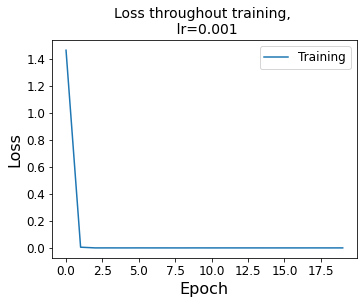

In [ ]:
plt.figure(figsize=(12, 4)) 

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Training')
# plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epoch', size=16)
plt.ylabel('Loss', size=16)
plt.xticks(size=12)
plt.yticks(size=12)
plt.title('Loss throughout training, \n lr={}'.format(lr), size=14)
plt.legend(prop={'size': 12})

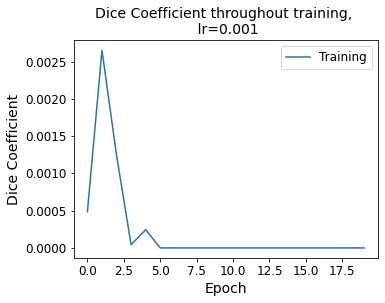

In [ ]:
plt.figure(figsize=(12, 4)) 

plt.subplot(1,2,2)
plt.plot(history.history['dice_coef'], label='Training')
# plt.plot(history.history['val_dice_coef'], label='Validation')
plt.xlabel('Epoch', size=14)
plt.ylabel('Dice Coefficient', size=14)
plt.xticks(size=12)
plt.yticks(size=12)
plt.title('Dice Coefficient throughout training, \n lr={}'.format(lr), size=14)
plt.legend(prop={'size': 12})

# Testing

### Load test data in TFRecords format

In [ ]:
print('Loading and preprocessing test data (non-empty masks)...')

test_non_empty_gcs_pattern = "gs://aneurysm_seg_orig/test_non_empty*"
test_non_empty_filenames = tf.io.gfile.glob(test_non_empty_gcs_pattern)
test_non_empty_ds = tf.data.TFRecordDataset(test_non_empty_filenames)

test_non_empty_ds = test_non_empty_ds.map(_parse_image_function)
test_non_empty_ds = test_non_empty_ds.map(_unpack_proto)
test_non_empty_ds = test_non_empty_ds.map(to_3_channels)

test_ds = prepare_data(test_non_empty_ds)

Loading and preprocessing test data (non-empty masks)...


In [ ]:
test_ds

<PrefetchDataset shapes: ((64, 256, 256, 3), (64, 256, 256)), types: (tf.float32, tf.int64)>

In [ ]:
test_pairs = list(test_ds.take(1))
test_images = [pair[0] for pair in test_pairs]
test_images_to_display = np.concatenate(test_images)

test_masks = [pair[1] for pair in test_pairs]
test_masks = np.concatenate(test_masks)

In [ ]:
print('Predicting masks on test data...')

test_preds = [model.predict(batch) for batch in test_images]
test_preds = np.concatenate(test_preds)

Predicting masks on test data...


### Display test images with true and predicted masks

In [ ]:
def compare_img_mask(images, masks, preds, img_num):

  """
  Display original image with mask, true mask and predicted mask for a specified image number
  
  Args:
  train_, test_ or valid_ + images/masks/preds
  """

  plt.figure(figsize=(12, 6)) 

  plt.subplot(1,3,1)
  plt.gca().set_title('Test Image {} with true mask'.format(img_num), size=14)
  a = images[img_num]#.reshape((256,256))
  b = masks[img_num]#.reshape((256,256))
  plt.imshow(mark_boundaries(a,b, mode='thick')) # display image with mask overlaid

  plt.subplot(1,3,2)
  plt.gca().set_title('True mask for test image {}'.format(img_num), size=14)
  # plt.imshow(masks[img_num].reshape((256,256)), cmap='gray') # display true masks for test data
  plt.imshow(masks[img_num], cmap='gray') # 3 colour channels

  plt.subplot(1,3,3)
  plt.gca().set_title('Predicted mask for test image {}'.format(img_num), size=14)
  plt.imshow(np.round(preds[img_num].reshape((256,256))), cmap='gray') # display predicted masks for test data

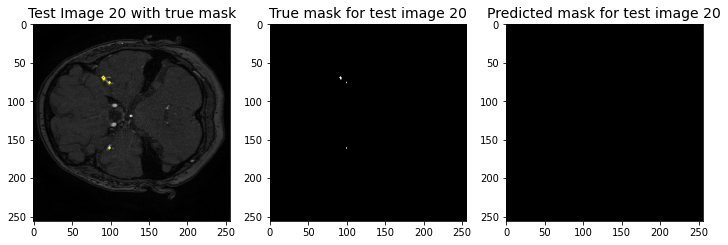

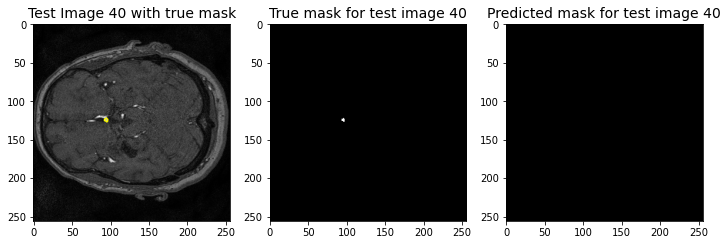

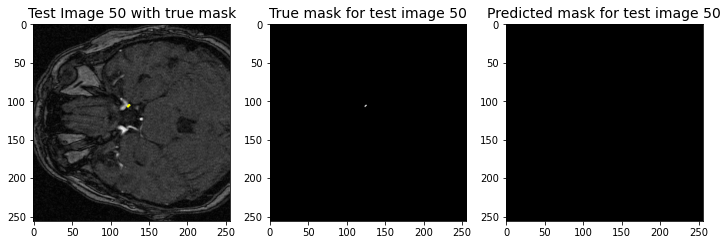

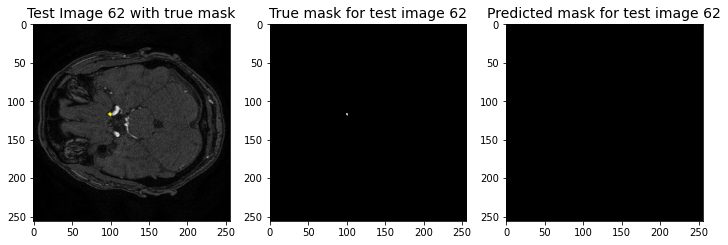

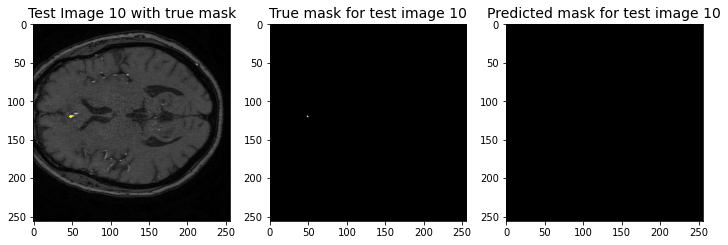

In [ ]:
for i in [20,40,50,62,10]:
  compare_img_mask(test_images_to_display, test_masks, test_preds, i)

In [ ]:
# print index of non-zero predicted masks

for i, img in enumerate(test_preds):
  if np.any(img != 0):
    print(i)

21
48
59
61


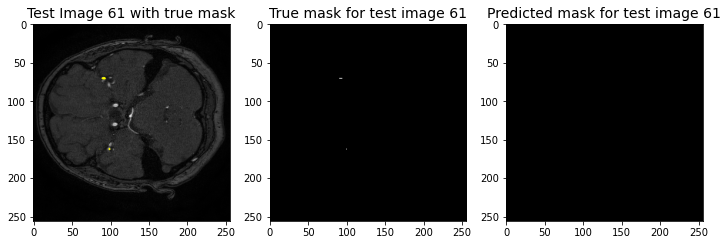

In [ ]:
# display a predicted mask

compare_img_mask(test_images_to_display, test_masks, test_preds, 61)

In [ ]:
# find number of non-empty true masks

tot = 0

for i, mask in enumerate(test_masks):
  if np.any(mask != 0):
    print(i)
    tot += 1

print('tot: {}'.format(tot))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
tot: 64


# Test Metrics

In [ ]:
# calculate dice coeff for each pair of true (test_masks) and predicted (test_preds) masks in the test set

dice_coeff_list = []
dice_coeff_dict = {}

for i in range(len(test_masks)):
  true_mask = test_masks[i]
  pred_mask = test_preds[i].reshape((256,256))
  pred_mask = np.round(pred_mask)
  dice_coeff = np.array(dice_coef(true_mask, pred_mask))
  dice_coeff_list.append(dice_coeff)
  dice_coeff_dict[i] = dice_coeff

In [ ]:
np.mean(dice_coeff_list), np.std(dice_coeff_list)

(0.668373, 0.43139228)

Text(0, 0.5, 'Number of Images')

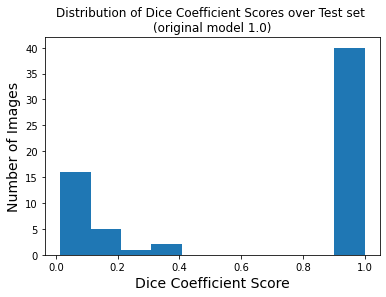

In [ ]:
plt.hist(dice_coeff_list)
plt.title('Distribution of Dice Coefficient Scores over Test set \n(original model 1.0)')
plt.xlabel('Dice Coefficient Score', size=14)
plt.ylabel('Number of Images', size=14)

In [ ]:
# create lists 'low' and 'high' that store indices of low and high scoring masks respectively

low = []
high = []

for key,val in dice_coeff_dict.items():
  if val<0.1:
    low.append(key)
  elif val>0.9:
    high.append(key)

len(low), len(high)

(12, 40)

In [ ]:
tot_empty = 0

for i in high:
  mask = test_masks[i]
  if np.all(mask == 0):
    print(i)
    tot_empty += 1

print('total empty: {}'.format(tot_empty)) # 40 out of 40 masks with high dice coeff scores are entirely 0

In [ ]:
tot_non_empty = 0

for i in low:
  mask = test_masks[i]
  if np.any(mask != 0):
    print(i)
    tot_non_empty += 1

print('total not empty: {}'.format(tot_non_empty)) # 40 out of 40 masks with high dice coeff scores are entirely 0

1
7
18
25
26
34
36
38
41
43
46
47
total not empty: 12


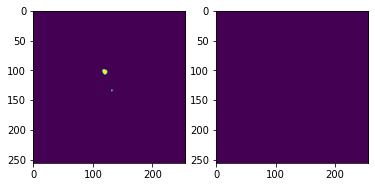

In [ ]:
# look at predicted masks that give low dice coeff score

mask_num = 7

plt.subplot(1,2,1)
plt.imshow(test_masks[mask_num].reshape((256,256)))

plt.subplot(1,2,2)
plt.imshow(test_preds[mask_num].reshape((256,256)))